In [20]:
import numpy as np
import pandas as pd
from datetime import date
import pickle
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error

In [2]:
RANDOM_STATE = 888

In [3]:
ANSWER_TEST_PATH = 'data/answers_test.csv'
users_data_df_PATH = 'data/data_test.csv'
DATA_TRAIN_FEATURES_PATH = 'data/data_train_features.csv'
DATA_TEST_FEATURES_PATH = 'data/data_test_features.csv'

### 1. Получаем данные. 

In [4]:
data_train  = pd.read_csv(DATA_TRAIN_FEATURES_PATH)

data_train.head()

,id,vas_id,target,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2814496,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
1,212196,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
2,3929509,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
3,2379697,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7
4,415308,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,7


In [6]:
print("ID уникален? ", data_train.index.is_unique)
print("Есть ли дубли в строках?", data_train.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((data_train.isnull().sum() > 0).sum()/data_train.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 97%


### 2. Разделим данные на тренировочную и тестовую выборки.

In [7]:
train_data, test_data = train_test_split(data_train, test_size=0.25, random_state=RANDOM_STATE)

### 3. Балансировка массивов.

0.0    0.944645
1.0    0.055355
Name: target, dtype: float64

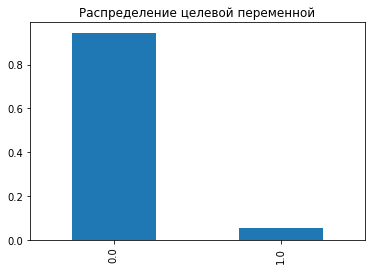

In [8]:
(data_train['target'].value_counts()/data_train['target'].shape[0]).plot(kind='bar', title='Распределение целевой переменной');
data_train['target'].value_counts()/data_train['target'].shape

Видно, что процент в данных имеется очень сильный дисбаланс в распределении классов.

Для того чтобы повысить к-во обучения модели. выполним балансировку данных на обучающей выборке. 
> Примечание - в принципе, это делать не обязательно, т.к. CatBoostClassifier досточно хорошо умеет работать с 
несбалансированными данныим (параметр - class_weights), но UnderSampling позволяет уменьшить объем данных,
и т.о. повысить скорость обучения.

In [9]:
ros = RandomUnderSampler(random_state=RANDOM_STATE)

x_train, y_train = ros.fit_resample(train_data.drop('target', axis=1), train_data['target'])
train_data = x_train

train_data.insert(2, "target", y_train.values)

E:\anaconda3\envs\recsys_env\lib\site-packages\IPython\core\interactiveshell.py:3377: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [10]:
print("Train")
print(train_data['target'].value_counts()/train_data['target'].shape[0])
print()
print("Test")
print(test_data['target'].value_counts()/test_data['target'].shape[0])

Train
0.0    0.5
1.0    0.5
Name: target, dtype: float64

Test
0.0    0.945209
1.0    0.054791
Name: target, dtype: float64


### 4. Обучение модели.

In [11]:
TASK = Task('binary', loss='logloss', metric='auc', greater_is_better=False)
TIMEOUT = 300000
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = RANDOM_STATE 
TARGET_NAME = 'target'
TEST_SIZE=0.2

In [12]:
roles = {'target': TARGET_NAME, 'drop': ['id']}

In [13]:
automl_model = TabularAutoML(task=TASK,
                            timeout=TIMEOUT,
                            cpu_limit = N_THREADS,
                            reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                            general_params= {'use_algos': [ ['lgb_tuned', 'cb_tuned'] ]},
                            tuning_params= {'max_tuning_iter': 10},
                        )

In [14]:
train_preds = automl_model.fit_predict(train_data, roles = roles)

### 5. Построение предсказаний на тестовой выборке, оценка к-ва модели. 

In [39]:
test_preds = automl_model.predict(test_data).data[:,0]

In [40]:
test_preds = [1 if i > 0.5 else 0 for i in test_preds]

In [41]:
y_test = test_data['target']

In [42]:
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[167079  24028]
 [  1274   9804]]


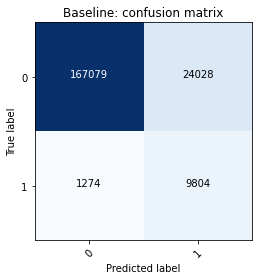

In [43]:
# TN               | FP(Type II error)|
#------------------|------------------|
# FN(Type I error) | TP               |

cm = confusion_matrix(y_test, test_preds)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

In [44]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    191107
         1.0       0.29      0.88      0.44     11078

    accuracy                           0.87    202185
   macro avg       0.64      0.88      0.68    202185
weighted avg       0.95      0.87      0.90    202185



In [45]:
fpr, tpr, roc_thresholds = roc_curve(y_test, test_preds)
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_preds)

Baseline: AUC_ROC = 0.880


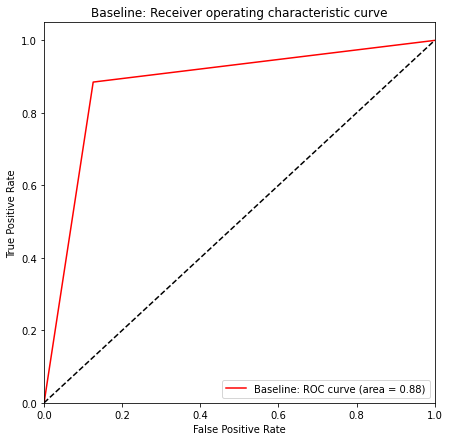

In [46]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.591


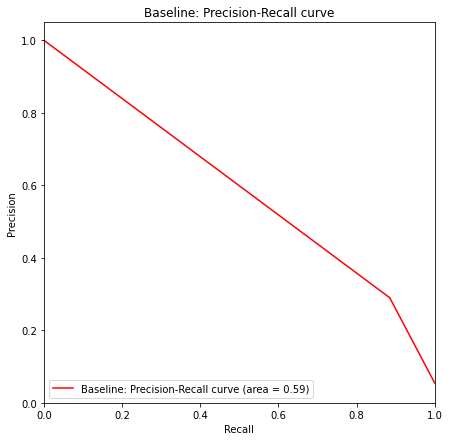

In [47]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

### 6. Запись обученной модели в файл.

In [48]:
with open('data/lama_model.pickle', 'wb') as f:
    pickle.dump(automl_model, f, protocol=pickle.HIGHEST_PROTOCOL)

### 7. Финальное предсказание.

In [49]:
with open('data/lama_model.pickle', 'rb') as f:
    automl_model =  pickle.load(f)

In [50]:
DATA_TEST_FEATURES_PATH = 'data/data_test_features.csv'

In [52]:
data_test  = pd.read_csv(DATA_TEST_FEATURES_PATH)

In [54]:
data_test.loc[(data_test['252'] > 1, '252')] = 2.0

In [63]:
test_preds = automl_model.predict(data_test).data[:,0]

In [64]:
y_result_pred = [1 if i > 0.5 else 0 for i in test_preds]

In [65]:
x_test = pd.read_csv(users_data_df_PATH)
x_test = x_test.drop('Unnamed: 0', axis=1)

In [66]:
x_test['target'] = y_result_pred

In [67]:
x_test.head()

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0
1,2000860,4.0,1548018000,0
2,1099444,2.0,1546808400,1
3,1343255,5.0,1547413200,1
4,1277040,2.0,1546808400,1


In [68]:
x_test.to_csv(ANSWER_TEST_PATH, index=False)